 ### Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader, Dataset
import torchvision
from torchvision.io import read_image
from torchvision import datasets as torchV_datasets
from torchvision import transforms, utils
from torchvision.utils import make_grid
from torchvision.models import resnet50, ResNet50_Weights
from torch import optim
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import os
import shutil
from distutils.dir_util import copy_tree
import glob as glob
import random
import collections
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# for dataset files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from matplotlib import pyplot as plt

def plot_training_curves(train_losses, val_accuracies):
    """Plot training loss and validation accuracy curves."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.plot(val_accuracies)
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (0.0 to 1.0)')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

### Utility Class
This class will move anime image folders from the dataset called anime-images-dataset to local colab directory

In [ ]:
class UtilityWorker():
    """
    Utility class for selecting anime datasets.

    Parameters:
        num_anime (int): Number of anime to include (used only for random selection).
        anime_list (list, optional): Specific list of anime names to include.
        seed (int): Random seed for reproducibility (only used for random selection).

    Notes:
        - If `anime_list` is provided, it overrides random selection.
        - Chosen anime are copied to the local working directory.
    """
    def __init__(self, num_anime=None, anime_list=None, seed=42):
        self.ANIME_IMAGES = "/content/drive/MyDrive/372 final project/datasets/anime_images"
        self.INPUT = "/content/subset_data"

        self._cleanup_subset_data()

        all_anime = os.listdir(self.ANIME_IMAGES)

        if anime_list is not None:
            missing = [a for a in anime_list if a not in all_anime]
            if missing:
                raise ValueError(f"The following anime are not found in dataset: {missing}")
            selected_anime = anime_list
        else:
            if num_anime is None:
                raise ValueError("Either 'anime_list' or 'num_anime' must be provided.")
            random.seed(seed)
            selected_anime = random.sample(all_anime, k=num_anime)

        print(f"The anime chosen are:\n{selected_anime}")

        self.copy_folder_helper(selected_anime)

        print(f"These anime can be found within folders of their own name in: {self.INPUT}")

    def _cleanup_subset_data(self):
        """Helper function to clean up the subset_data directory."""
        if os.path.exists(self.INPUT):
            print(f"Cleaning up existing data in: {self.INPUT}")
            shutil.rmtree(self.INPUT)
        os.makedirs(self.INPUT, exist_ok=True)

    def copy_folder_helper(self, animelist):
        """Helper function that does the actual copying."""
        for anime in animelist:
            src = os.path.join(self.ANIME_IMAGES, anime)
            dest = os.path.join(self.INPUT, anime)
            os.makedirs(dest, exist_ok=True)
            copy_tree(src, dest)

In [ ]:
my_anime_list = [
    "A Silent Voice",
    "Attack on Titan",
    "Death Parade",
    "Haikyu!!",
    "Hunter x Hunter",
    "ReLife",
    "Steins Gate",
    "Violet Evergarden",
    "Yona of the Dawn",
    "Your Lie in April"
]
#utility = UtilityWorker(anime_list=my_anime_list)
utility = UtilityWorker(num_anime=30)

Cleaning up existing data in: /content/subset_data
The anime chosen are:
['Nichijou', 'Angel Beats!', 'A Place Further Than The Universe', 'Ping Pong the Animation', 'Death Parade', 'Death Note', 'Steins Gate', 'Attack on Titan', 'Your Lie in April', 'Neon Genesis Evangelion', 'Bakemonogatari', 'My Teen Romantic Comedy', 'Laid-Back Camp', 'A Silent Voice', 'Violet Evergarden', 'Nana', 'No Game No Life', 'Yona of the Dawn', 'ReZero', 'Code Geass', 'Maid Sama!', 'Haikyu!!', 'Hyouka', 'Chihayafuru', 'Clannad', 'Sound! Euphonium', 'Tsukigakirei', 'Hunter x Hunter', 'Kamisama Kiss', 'ReLife']
These anime can be found within folders of their own name in: /content/subset_data


### Data Class

In [ ]:
class Data():
    def __init__(self):
        self.INPUT = "/content/subset_data"
        self.separator = ""

    def get_full_dataset(self, transform=None):
        """
        Loads the dataset with a specified transform.
        If transform is None, uses basic ToTensor for splitting.
        """
        if transform is None:
            transform = transforms.Compose([transforms.ToTensor()])

        self.full_dataset = torchV_datasets.ImageFolder(self.INPUT, transform=transform)
        print(f"Full dataset details:")
        print(self.full_dataset)
        print(f"Classes: {self.full_dataset.classes}")
        print(self.separator)
        return self.full_dataset

    def get_train_val_test_splits(self, dataset, val_split=0.2, test_split=0.2):
        """
        Splits the dataset into train, validation, and test sets.
        Uses stratification to ensure class distribution is maintained.
        """
        dataset_size = len(dataset)
        indices = list(range(dataset_size))
        try:
            targets = dataset.targets
        except AttributeError:
            print("Warning: Could not find .targets attribute. Falling back to slow label extraction.")
            targets = [label for _, label in dataset]


        train_val_idx, test_idx = train_test_split(
            indices,
            test_size=test_split,
            stratify=targets,
            random_state=42
        )


        train_val_targets = [targets[i] for i in train_val_idx]
        val_split_adjusted = val_split / (1.0 - test_split)


        train_idx, val_idx = train_test_split(
            train_val_idx,
            test_size=val_split_adjusted,
            stratify=train_val_targets,
            random_state=42
        )

        print(f"Full dataset size: {dataset_size}")
        print(f"Train indices: {len(train_idx)}")
        print(f"Validation indices: {len(val_idx)}")
        print(f"Test indices: {len(test_idx)}")
        print(self.separator)


        return train_idx, val_idx, test_idx


    def count_labels_in_dataset(self, dataset, indices, dataset_name="optional"):
        """Counts labels given a dataset and a list of indices."""
        if dataset_name != "optional":
            print(f"Counting labels in {dataset_name} dataset....")


        labels = [dataset.targets[i] for i in indices]

        print(f"Label counts are:\n{collections.Counter(labels)}")
        print(f"Number of classes: {len(collections.Counter(labels))}")
        print(self.separator)

In [ ]:
# Data Loading and Splitting
data_obj = Data()

full_dataset_for_splitting = data_obj.get_full_dataset(transform=None)

train_idx, val_idx, test_idx = data_obj.get_train_val_test_splits(
    full_dataset_for_splitting, val_split=0.15, test_split=0.15
)

data_obj.count_labels_in_dataset(full_dataset_for_splitting, train_idx, "train")
data_obj.count_labels_in_dataset(full_dataset_for_splitting, val_idx, "validation")
data_obj.count_labels_in_dataset(full_dataset_for_splitting, test_idx, "test")

Full dataset details:
Dataset ImageFolder
    Number of datapoints: 11097
    Root location: /content/subset_data
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Classes: ['A Place Further Than The Universe', 'A Silent Voice', 'Angel Beats!', 'Attack on Titan', 'Bakemonogatari', 'Chihayafuru', 'Clannad', 'Code Geass', 'Death Note', 'Death Parade', 'Haikyu!!', 'Hunter x Hunter', 'Hyouka', 'Kamisama Kiss', 'Laid-Back Camp', 'Maid Sama!', 'My Teen Romantic Comedy', 'Nana', 'Neon Genesis Evangelion', 'Nichijou', 'No Game No Life', 'Ping Pong the Animation', 'ReLife', 'ReZero', 'Sound! Euphonium', 'Steins Gate', 'Tsukigakirei', 'Violet Evergarden', 'Yona of the Dawn', 'Your Lie in April']

Full dataset size: 11097
Train indices: 7767
Validation indices: 1665
Test indices: 1665

Counting labels in train dataset....
Label counts are:
Counter({21: 266, 18: 266, 13: 266, 12: 266, 19: 266, 4: 266, 29: 266, 14: 266, 23: 266, 27: 266, 28: 266, 17: 266, 25: 266, 3: 

### Dataloaders
Creating the train and test dataloaders in preparation for training.

In [ ]:
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]
data_root = "/content/subset_data"

# training transforms with augmentations
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=normalize_mean, std=normalize_std)
])

# validation/test transforms (no augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=normalize_mean, std=normalize_std)
])

# create *separate* ImageFolder datasets for each transform
train_dataset_full = torchV_datasets.ImageFolder(
    data_root,
    transform=train_transforms
)

val_test_dataset_full = torchV_datasets.ImageFolder(
    data_root,
    transform=val_test_transforms
)

# create Subsets using the *correct* base dataset and the indices
train_dataset = Subset(train_dataset_full, train_idx)
val_dataset = Subset(val_test_dataset_full, val_idx)
test_dataset = Subset(val_test_dataset_full, test_idx)

print("Created separate transforms for train and val/test sets.")
print(f"Train transforms: {train_transforms}")
print(f"Val/Test transforms: {val_test_transforms}")


BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

x,y = next(iter(train_dataloader))
print(f"Train batch data shapes: {x.shape, y.shape}")
x,y = next(iter(val_dataloader))
print(f"Validation batch data shapes: {x.shape, y.shape}")
x,y = next(iter(test_dataloader))
print(f"Test batch data shapes: {x.shape, y.shape}")

Created separate transforms for train and val/test sets.
Train transforms: Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Val/Test transforms: Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Train batch data shapes: (torch.Size([32, 3, 224, 224]), torch.Size([32]))
Validation batch data shapes: (torch.Size([32, 3, 224, 224]), torch.Size([32]))
Test batch data shapes: (torch.Size([32, 3, 224, 224]), torch.Size([32]))


### Plotting Images

In [ ]:
def plot_img(img, y=None, color=True, class_names=None, num_classes=None, images_per_row=None):
    # Define mean and std based on the unified_transforms used for normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).to(img.device)
    std = torch.tensor([0.229, 0.224, 0.225]).to(img.device)

    # Inverse normalization
    img_unnormalized = img * std[:, None, None] + mean[:, None, None]

    # Clip values to [0, 1] after unnormalization
    img_unnormalized = torch.clamp(img_unnormalized, 0, 1)

    npimg = img_unnormalized.cpu().numpy()
    npimg_T = np.transpose(npimg, (1, 2, 0))

    ax = plt.gca() # Get current axes to plot on
    ax.imshow(npimg_T)
    ax.set_title('Image samples from each class')

    # Customizing axes based on class_names
    if class_names and num_classes and images_per_row:
        original_img_height = 224 # Assuming 224x224 from unified_transforms
        padding = 1 # From make_grid(padding=1)

        y_tick_positions = []
        for i in range(num_classes):
            # Calculate the center y-coordinate for each row of images
            pos = i * (original_img_height + padding) + padding + (original_img_height / 2)
            y_tick_positions.append(pos)

        ax.set_yticks(y_tick_positions)
        ax.set_yticklabels(class_names)
        ax.set_ylabel('Anime Class', rotation=0, ha='right', va='center', fontsize=12)
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) # Remove x-axis ticks and labels
        ax.tick_params(axis='y', which='both', left=False, right=False) # Remove y-axis ticks
        ax.set_xticks([]) # Ensure no x-axis labels
    else:
        ax.axis('on') # Default behavior if no class names are provided

def plot_tensor(tensor):
    # Assume data_obj is globally accessible and initialized from the Data class
    # to get class names.
    if 'data_obj' in globals() and hasattr(data_obj, 'full_dataset') and hasattr(data_obj.full_dataset, 'classes'):
        all_class_names = data_obj.full_dataset.classes
    else:
        all_class_names = None
        print("Warning: Could not retrieve class names from data_obj. Displaying default axes.")

    num_images_to_show_per_class = 1 # Changed to 1
    num_images_per_row = num_images_to_show_per_class # Fixed as nrow in utils.make_grid

    plt.figure(figsize=(60,25))

    images_by_class = collections.defaultdict(list)
    classes_found = set() # Track classes for which an image has been found

    for i in range(len(tensor)): # Iterate through the subset to collect images
        img, label = tensor[i]
        if label not in classes_found: # Only take one image per class
            images_by_class[label].append(img)
            classes_found.add(label)
        if len(classes_found) == len(all_class_names): # Optimization: stop if all classes found
            break

    # Get sorted list of actual classes present in the tensor
    actual_labels_in_tensor = sorted(images_by_class.keys())
    num_classes_in_display = len(actual_labels_in_tensor)

    # Get class names for only the displayed classes
    class_names_to_display = [all_class_names[label] for label in actual_labels_in_tensor] if all_class_names else None

    X_show = []
    for label in actual_labels_in_tensor:
        X_show.extend(images_by_class[label])

    X_grid = utils.make_grid(X_show, nrow=num_images_per_row, padding=1)

    plot_img(X_grid, y=None, color=True,
             class_names=class_names_to_display,
             num_classes=num_classes_in_display,
             images_per_row=num_images_per_row)

    plt.show()

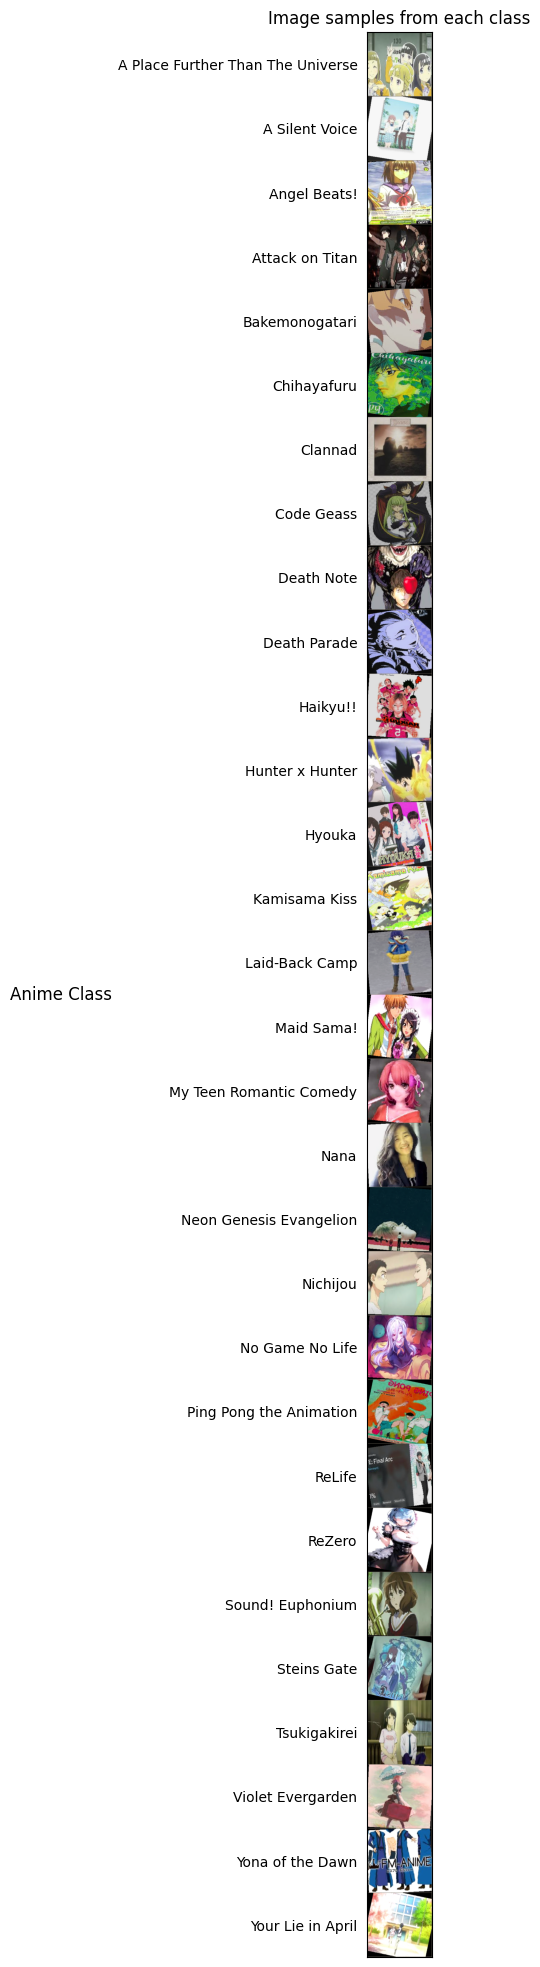

In [ ]:
plot_tensor(train_dataset)

### Training


In [ ]:
model = resnet50(weights="IMAGENET1K_V2")
num_classes = len(data_obj.full_dataset.classes)

# feature extraction
for param in model.parameters():
    param.requires_grad = False

print(f"ImageNet Defaults: {model.fc}")
fc_inputs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes),
)
model = model.to(device)
print(f"After update: {model.fc}")
print(data_obj.separator)

criterion = nn.CrossEntropyLoss(reduction="mean", label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
epochs = 25

ImageNet Defaults: Linear(in_features=2048, out_features=1000, bias=True)
After update: Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=256, out_features=30, bias=True)
)



In [ ]:
def train(epochs, model, train_loader, val_loader, criterion, optimizer, device):
    """
    Main training and validation loop with mixed precision support.
    """
    print("Starting training...")
    train_losses, val_accuracies = [], []

    best_val_accuracy = 0.0
    epochs_no_improve_ctr = 0
    patience = 5
    start_time = time.time()

    # mixed precision
    scaler = torch.amp.GradScaler('cuda')

    for epoch in range(epochs):
        # training
        model.train()
        total_train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # forward pass with autocast
            with torch.amp.autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # backward pass and optimization with scaler
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_train_loss += loss.item()
            predicted_class = outputs.argmax(dim=1)
            train_total += labels.size(0)
            train_correct += (predicted_class == labels).sum().item()
            train_pbar.set_postfix({'loss': loss.item()})

        avg_train_loss = total_train_loss / len(train_loader)
        epoch_train_acc = train_correct / train_total
        train_losses.append(avg_train_loss)

        # validation
        model.eval()
        total_val_loss = 0.0
        val_correct = 0
        val_total = 0

        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Valid]", leave=False)
        with torch.no_grad():
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)

                with torch.amp.autocast('cuda'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                total_val_loss += loss.item()
                predicted_class = outputs.argmax(dim=1)
                val_total += labels.size(0)
                val_correct += (predicted_class == labels).sum().item()
                val_pbar.set_postfix({'loss': loss.item()})

        avg_val_loss = total_val_loss / len(val_loader)
        epoch_val_acc = val_correct / val_total
        val_accuracies.append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Train Acc: {epoch_train_acc*100:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {epoch_val_acc*100:.2f}%")

        if epoch_val_acc > best_val_accuracy:
            best_val_accuracy = epoch_val_acc
            epochs_no_improve_ctr = 0
        else:
            epochs_no_improve_ctr += 1
            if epochs_no_improve_ctr >= patience:
                print(f"Early stopping after {epoch+1} epochs. No improvement for {patience} epochs.")
                break

    total_time = time.time() - start_time
    print(f"\nTraining finished in {total_time:.2f} seconds.")

    return train_losses, val_accuracies

In [ ]:
train_losses_list, val_accuracies_list = train(
    epochs=epochs,
    model=model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device
)

Starting training...


Epoch 1/25 [Train]:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 1/25 [Valid]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1/25 | Train Loss: 3.3405 | Train Acc: 11.60% | Val Loss: 3.2386 | Val Acc: 24.08%


Epoch 2/25 [Train]:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 2/25 [Valid]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2/25 | Train Loss: 3.1234 | Train Acc: 25.67% | Val Loss: 3.0067 | Val Acc: 30.93%


Epoch 3/25 [Train]:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 3/25 [Valid]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3/25 | Train Loss: 2.9158 | Train Acc: 30.44% | Val Loss: 2.8190 | Val Acc: 36.58%


Epoch 4/25 [Train]:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 4/25 [Valid]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4/25 | Train Loss: 2.7474 | Train Acc: 35.32% | Val Loss: 2.6733 | Val Acc: 39.46%


Epoch 5/25 [Train]:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 5/25 [Valid]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5/25 | Train Loss: 2.6264 | Train Acc: 39.23% | Val Loss: 2.5784 | Val Acc: 41.38%


Epoch 6/25 [Train]:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 6/25 [Valid]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6/25 | Train Loss: 2.5166 | Train Acc: 41.44% | Val Loss: 2.4978 | Val Acc: 42.64%


Epoch 7/25 [Train]:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 7/25 [Valid]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7/25 | Train Loss: 2.4314 | Train Acc: 44.46% | Val Loss: 2.4196 | Val Acc: 44.98%


Epoch 8/25 [Train]:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 8/25 [Valid]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8/25 | Train Loss: 2.3658 | Train Acc: 46.03% | Val Loss: 2.3645 | Val Acc: 46.19%


Epoch 9/25 [Train]:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 9/25 [Valid]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9/25 | Train Loss: 2.3151 | Train Acc: 47.08% | Val Loss: 2.3336 | Val Acc: 47.81%


Epoch 10/25 [Train]:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 10/25 [Valid]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10/25 | Train Loss: 2.2638 | Train Acc: 49.27% | Val Loss: 2.2832 | Val Acc: 48.89%


Epoch 11/25 [Train]:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 11/25 [Valid]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 11/25 | Train Loss: 2.2061 | Train Acc: 50.42% | Val Loss: 2.2379 | Val Acc: 50.09%


Epoch 12/25 [Train]:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 12/25 [Valid]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 12/25 | Train Loss: 2.1855 | Train Acc: 50.46% | Val Loss: 2.2198 | Val Acc: 50.27%


Epoch 13/25 [Train]:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 13/25 [Valid]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 13/25 | Train Loss: 2.1430 | Train Acc: 52.45% | Val Loss: 2.1934 | Val Acc: 50.87%


Epoch 14/25 [Train]:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 14/25 [Valid]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 14/25 | Train Loss: 2.1028 | Train Acc: 54.17% | Val Loss: 2.1651 | Val Acc: 52.13%


Epoch 15/25 [Train]:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 15/25 [Valid]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 15/25 | Train Loss: 2.0759 | Train Acc: 54.62% | Val Loss: 2.1419 | Val Acc: 52.49%


Epoch 16/25 [Train]:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 16/25 [Valid]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 16/25 | Train Loss: 2.0480 | Train Acc: 55.75% | Val Loss: 2.1243 | Val Acc: 52.79%


Epoch 17/25 [Train]:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 17/25 [Valid]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 17/25 | Train Loss: 2.0157 | Train Acc: 57.02% | Val Loss: 2.0953 | Val Acc: 54.05%


Epoch 18/25 [Train]:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 18/25 [Valid]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 18/25 | Train Loss: 1.9927 | Train Acc: 56.77% | Val Loss: 2.0883 | Val Acc: 54.65%


Epoch 19/25 [Train]:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 19/25 [Valid]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 19/25 | Train Loss: 1.9591 | Train Acc: 58.23% | Val Loss: 2.0662 | Val Acc: 55.50%


Epoch 20/25 [Train]:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 20/25 [Valid]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 20/25 | Train Loss: 1.9457 | Train Acc: 58.72% | Val Loss: 2.0584 | Val Acc: 55.74%


Epoch 21/25 [Train]:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 21/25 [Valid]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 21/25 | Train Loss: 1.9207 | Train Acc: 58.85% | Val Loss: 2.0456 | Val Acc: 55.38%


Epoch 22/25 [Train]:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 22/25 [Valid]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 22/25 | Train Loss: 1.8883 | Train Acc: 60.27% | Val Loss: 2.0251 | Val Acc: 55.56%


Epoch 23/25 [Train]:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 23/25 [Valid]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 23/25 | Train Loss: 1.8833 | Train Acc: 60.78% | Val Loss: 2.0139 | Val Acc: 56.58%


Epoch 24/25 [Train]:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 24/25 [Valid]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 24/25 | Train Loss: 1.8631 | Train Acc: 61.35% | Val Loss: 2.0058 | Val Acc: 56.64%


Epoch 25/25 [Train]:   0%|          | 0/243 [00:00<?, ?it/s]

Epoch 25/25 [Valid]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 25/25 | Train Loss: 1.8441 | Train Acc: 61.21% | Val Loss: 1.9991 | Val Acc: 57.12%

Training finished in 2118.70 seconds.


Plotting training curves...


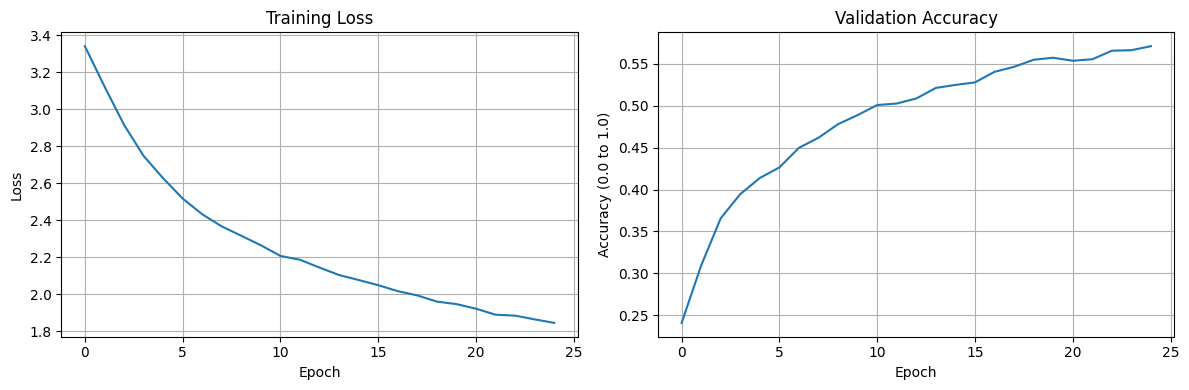

In [ ]:
print("Plotting training curves...")
plot_training_curves(train_losses_list, val_accuracies_list)

In [ ]:
save_dir = "/content/drive/MyDrive/372 final project/models/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
final_model_path = os.path.join(save_dir, "trained_resnet50_final_simple.pt")
torch.save(model.state_dict(), final_model_path)
print(f"Final model saved to {final_model_path}")
print(data_obj.separator)

Final model saved to /content/drive/MyDrive/372 final project/models/trained_resnet50_final_simple.pt



### Final Evaluation on Test Set

In [ ]:
# loading saved weights if needed
final_model_path = "/content/drive/MyDrive/372 final project/models/trained_resnet50_final_simple.pt"

model.load_state_dict(torch.load(final_model_path, map_location=device))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
print("\n--- Final Test Evaluation ---")
model.eval()
correct = 0
total = 0
test_loss = 0.0
all_true_labels = []
all_predicted_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

avg_test_loss = test_loss / len(test_dataloader)
test_accuracy = correct / total
print(f"\nFinal Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Average Test Loss: {avg_test_loss:.4f}")


--- Final Test Evaluation ---


Testing:   0%|          | 0/53 [00:00<?, ?it/s]


Final Test Accuracy: 58.26%
Average Test Loss: 1.9703


### Error Analysis
Generate and visualize a confusion matrix

Report the top 10 misclassifications from the confusion matrix, showing predicted class, actual class, and the number of instances for each

Future: summarize error analysis findings

In [ ]:
from sklearn.metrics import confusion_matrix

class_names = data_obj.full_dataset.classes
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[34  1  0  1  0  0  1  0  0  0  0  0  0  0  3  1  1  0  1  3  1  1  0  1
   0  2  2  0  0  2]
 [ 0 23  1  0  0  0  1  0  0  0  0  2  0  1  0  2  1  0  0  0  0  1  1  0
   1  0  2  2  2  1]
 [ 1  0 29  2  1  1  1  0  0  3  0  2  0  0  0  2  0  1  0  0  1  0  0  0
   0  2  0  3  4  4]
 [ 0  0  0 30  0  0  2  3  3  0  1  0  1  1  0  0  2  3  0  0  0  1  3  1
   0  6  0  0  0  0]
 [ 1  0  0  0 12  0  0  4  0  1  6  1  1  4  1  3  3  2  3  4  2  2  0  1
   1  2  0  0  2  1]
 [ 0  2  0  1  0 33  1  0  0  0  2  0  0  2  0  4  1  1  0  0  0  0  2  2
   0  0  1  3  2  0]
 [ 1  1  3  1  0  3 27  1  0  0  0  0  0  0  0  3  0  6  0  3  0  0  1  0
   2  1  1  0  2  1]
 [ 0  0  0  0  0  0  0 37  1  1  0  1  0  0  2  3  0  0  2  0  1  1  0  1
   2  1  1  1  2  0]
 [ 0  0  0  2  0  1  1  1 34  0  1  0  0  0  0  6  0  3  2  0  0  0  0  1
   0  2  0  1  1  0]
 [ 0  0  1  0  0  0  1  0  2 36  2  2  0  0  0  0  0  1  0  0  1  3  1  2
   0  1  1  0  1  1]
 [ 0  0  0  0  0  1  0  0  1  0 

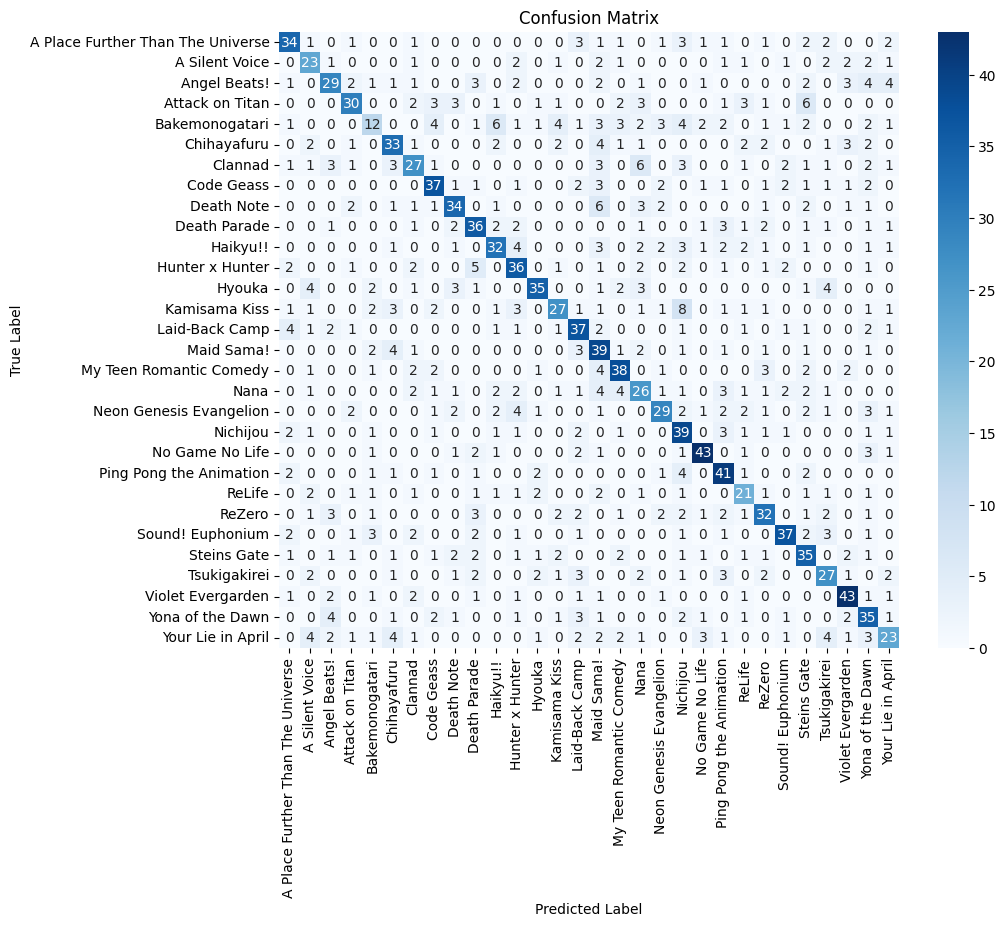

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# top 10 misclassifications

misclassifications = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j:
            count = conf_matrix[i, j]
            if count > 0:
                misclassifications.append({
                    'true_class': class_names[i],
                    'predicted_class': class_names[j],
                    'count': count
                })

top_misclassifications = sorted(misclassifications, key=lambda x: x['count'], reverse=True)[:10]

print("\nTop 10 Misclassifications:")
for item in top_misclassifications:
    print(f"  True: {item['true_class']}, Predicted: {item['predicted_class']}, Instances: {item['count']}")


Top 10 Misclassifications:
  True: Kamisama Kiss, Predicted: Nichijou, Instances: 8
  True: Attack on Titan, Predicted: Steins Gate, Instances: 6
  True: Bakemonogatari, Predicted: Haikyu!!, Instances: 6
  True: Clannad, Predicted: Nana, Instances: 6
  True: Death Note, Predicted: Maid Sama!, Instances: 6
  True: Hunter x Hunter, Predicted: Death Parade, Instances: 5
  True: Angel Beats!, Predicted: Yona of the Dawn, Instances: 4
  True: Angel Beats!, Predicted: Your Lie in April, Instances: 4
  True: Bakemonogatari, Predicted: Code Geass, Instances: 4
  True: Bakemonogatari, Predicted: Kamisama Kiss, Instances: 4
